In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import random
from networkx.algorithms import community
from sklearn.cluster import DBSCAN
from community import community_louvain
from scipy import stats
from scipy.stats import norm
import h5py
import pickle

from mpl_toolkits.mplot3d.art3d import Line3DCollection
import plotly.graph_objects as go
#plot 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter
import seaborn as sns

In [3]:
df_mm9 = pd.read_csv("/shareb/mliu/HiMulti/ref_data/mm9.chrom.sizes",sep="\t",header=None)
df_mm9.columns = ['chrom','size']
resolution = 40000
bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm9.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")
df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))
chr_list = list(bin_table_df['chrom'].unique())

## load data

In [4]:
# 读取距离矩阵
def read_distance_matrices(h5_file, chromosome):
    with h5py.File(h5_file, 'r') as f:
        distance_matrices = f[chromosome][:]
    return distance_matrices
def plot_distance_matrix(matrix):
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Distance Matrix Heatmap")
    plt.show()
    
def visualize_graph(G):
    pos = nx.spring_layout(G)  # 使用 spring 布局绘制图
    weights = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', edge_color='gray', linewidths=1, font_size=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color='red')
    plt.title("Clique Graph Visualization")
    plt.show()


In [5]:
# 主程序
chromosome = 'chr6'
h5_file = f'/shareb/mliu/HiMulti/1-validation_multi/distance_cells_{chromosome}.h5'
distance_matrices = read_distance_matrices(h5_file, chromosome)

MemoryError: Unable to allocate 19.9 GiB for an array with shape (191, 3738, 3738) and data type float64

In [108]:


# 查找团
def find_cliques(contact_graph, min_size=3,max_body=5):
    #最少有3个
    cliques = [clique for clique in nx.find_cliques(contact_graph) if (len(clique) >= min_size and len(clique) <= max_body)]
    return cliques







def build_clique_graph(real_frequencies):
    G = nx.Graph()
    for clique, frequency in real_frequencies.items():
        G.add_edge(clique[0], clique[1], weight=frequency)
        G.add_edge(clique[0], clique[2], weight=frequency)
        G.add_edge(clique[1], clique[2], weight=frequency)
    return G

def louvain_clustering(G):
    partition = community_louvain.best_partition(G, weight='weight')
    return partition

def calculate_cluster_frequencies(partition, real_frequencies):
    cluster_frequencies = defaultdict(float)
    cluster_nodes = defaultdict(list)
    
    for node, cluster_id in partition.items():
        cluster_nodes[cluster_id].append(node)
    
    for clique, frequency in real_frequencies.items():
        for cluster_id, nodes in cluster_nodes.items():
            if set(clique).intersection(nodes):
                cluster_frequencies[cluster_id] += frequency
                break
    
    return cluster_frequencies, cluster_nodes
def merge_frequencies(partition, real_frequencies):
    merged_frequencies = {}
    for triplet, frequency in real_frequencies.items():
        cluster_ids = tuple(sorted(set(partition[node] for node in triplet)))
        if cluster_ids in merged_frequencies:
            merged_frequencies[cluster_ids] += frequency
        else:
            merged_frequencies[cluster_ids] = frequency
    return merged_frequencies

In [109]:
#load d_list.pkl
with open("../2-gam/t_list.pkl","rb") as f:
    t_list = pickle.load(f)

In [7]:
def proximity_matrices(distance_matrices, thresholds):
    # 创建一个与输入数组相同形状的数组，用于存储结果
    result = np.zeros_like(distance_matrices, dtype=int)
    
    # 遍历每个矩阵和对应的阈值
    for i, (matrix, threshold) in enumerate(zip(distance_matrices, thresholds)):
        mask = (matrix <= threshold) & ~np.isnan(matrix)
        result[i][mask] = 1
    defaultdict
    return result

In [110]:
proximity_matrix_list = proximity_matrices(distance_matrices,t_list)

In [9]:

def build_contact_graph(pairwise_contacts, resolution, min_distance=5000000):
    graph = nx.Graph()
    num_nodes = pairwise_contacts.shape[0]
    min_bin_distance = min_distance // resolution  # 将最小距离转换为bin数
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if pairwise_contacts[i, j] and abs(i - j) > min_bin_distance:
                #有接触并且满足线性距离的限制
                graph.add_edge(i, j)
    return graph


def calculate_multibody_frequencies(pairwise_contacts_list,max_distance,min_size,max_size):
    #所有的
    multibody_counts = defaultdict(int)
    num_matrices = len(pairwise_contacts_list)#细胞的数量
    
    #分别处理每个细胞
    for pairwise_contacts in pairwise_contacts_list:
        contact_graph = build_contact_graph(pairwise_contacts, 40000,max_distance)
        #会很慢吗
        cliques = find_cliques(contact_graph,min_size,max_size)
        print(len(cliques),cliques)
        for clique in cliques:
            multibody_counts[tuple(sorted(clique))] += 1

    multibody_frequencies = {key: value / num_matrices for key, value in multibody_counts.items()}
    return multibody_frequencies

## 1.得到候选三元组

### clique

In [111]:
max_distance = 40000 #线性距离 不做要求
min_size = 3
max_size = 3


real_frequencies = calculate_multibody_frequencies(proximity_matrix_list,max_distance,min_size,max_size)

31 [[80, 98, 96], [80, 98, 87], [80, 99, 96], [920, 928, 931], [1484, 1538, 1486], [1484, 1538, 1534], [1484, 1538, 1535], [1484, 1486, 1537], [1484, 1535, 1537], [1659, 1664, 1669], [1659, 1664, 1670], [1659, 1669, 1832], [1659, 1669, 1831], [1659, 1832, 1852], [1662, 3149, 3156], [1677, 1832, 1851], [1677, 1832, 1852], [1686, 2869, 1688], [1686, 2869, 2880], [1687, 1922, 1693], [1688, 1922, 1693], [1688, 1922, 2062], [1688, 1692, 3961], [2013, 2883, 2049], [2045, 2881, 2865], [2045, 2063, 2865], [2210, 2222, 2218], [2218, 2225, 2221], [2852, 3888, 3890], [2853, 3888, 3890], [3888, 3893, 3902]]
1755 [[80, 822, 661], [82, 486, 815], [83, 728, 138], [83, 137, 153], [83, 138, 153], [83, 138, 231], [84, 105, 156], [84, 155, 106], [84, 155, 146], [84, 156, 106], [84, 156, 146], [85, 155, 106], [85, 155, 146], [86, 129, 145], [86, 129, 797], [86, 130, 798], [88, 114, 126], [88, 125, 111], [92, 98, 185], [92, 198, 122], [94, 200, 101], [94, 200, 102], [95, 216, 123], [96, 190, 194], [97, 174

### 社区检测（不好）

In [12]:
proba_matrix = np.mean(proximity_matrix_list, axis=0)
#对角线设为nan
np.fill_diagonal(proba_matrix, np.nan)

In [41]:
def build_graph_from_matrix(proba_matrix):
    G = nx.Graph()
    for i in range(proba_matrix.shape[0]):
        for j in range(i + 1, proba_matrix.shape[1]):  # 避免自环且不重复添加边
            if proba_matrix[i, j] > 0:  # 只有当概率大于0时才添加边
                G.add_edge(i, j, weight=proba_matrix[i, j])
    return G
def detect_communities(G):
    # 使用基于模块度的社区检测算法
    partition = community_louvain.best_partition(G, weight='weight',resolution=0.9)
    return partition
def visualize_graph(G, partition):
    # 为每个社区分配一个颜色
    community_colors = {comm_id: i for i, comm_id in enumerate(set(partition.values()))}
    colors = [community_colors[partition[node]] for node in G.nodes()]

    # 为每个社区的颜色生成一个颜色映射
    cmap = plt.cm.get_cmap('viridis', max(community_colors.values()) + 1)

    # 使用NetworkX绘制图形
    pos = nx.spring_layout(G)  # 使用spring布局
    nx.draw_networkx(G, pos, node_color=colors, node_size=40, cmap=cmap, with_labels=False)

    # 显示图例
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(community_colors[comm_id]), markersize=10, label=f'Community {comm_id}') for comm_id in community_colors]
    plt.legend(handles=handles, title="Communities")

    plt.title("Network Visualization with Community Coloring")
    plt.show()

/tmp/ipykernel_148934/3519777830.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(community_colors.values()) + 1)


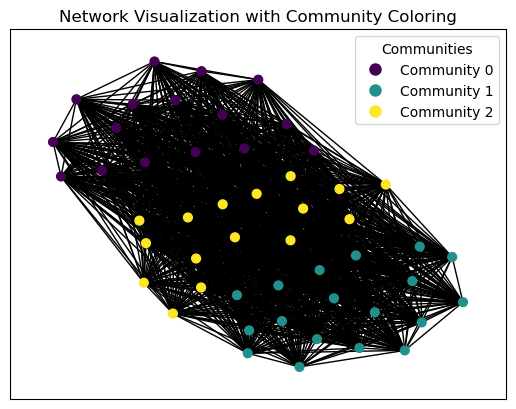

In [42]:

G = build_graph_from_matrix(proba_matrix[100:150,100:150])
partition = detect_communities(G)
visualize_graph(G, partition)

## 2.计算

In [125]:
# 转换为DataFrame
df = pd.DataFrame(list(real_frequencies.items()), columns=['triplet', 'frequency'])
df[['A', 'B', 'C']] = pd.DataFrame(df['triplet'].tolist(), index=df.index)
df['exp'] = None
df['obs'] = None
df['O/E'] = None
df['obs_distance'] = None
df['exp_distance'] = None
df['distance_pvalue'] = None

In [130]:
def proximity_frequency_two(x,y,proximity_matrix_list):
    close_count = 0
    total_cells = proximity_matrix_list.shape[0]
    for i in range(total_cells):
        if proximity_matrix_list[i][x,y] == 1:
            close_count += 1
    return close_count / total_cells

def proximity_frequency_three(x,y,z,proximity_matrix_list):
    close_count = 0
    total_cells = proximity_matrix_list.shape[0]
    for i in range(total_cells):
        if proximity_matrix_list[i][x,y] == 1 and proximity_matrix_list[i][y,z] == 1 and proximity_matrix_list[i][z,x] == 1:
            close_count += 1
    return close_count / total_cells

def generate_random_indices(chr_idx_list, span_range, idx1, idx2,idx3):
    random_indices = []
    for _ in range(10):
        index1_random = random.choice(chr_idx_list[:-span_range])
        index2_random = index1_random + (idx2 - idx1)
        index3_random = index1_random + (idx3 - idx1)
        random_indices.append([(index1_random, index2_random, index3_random)])
    return random_indices

def count_max_distance(distance_matrices,idx_a,idx_b,idx_c):
    max_distance_list = []
    for i in range(len(distance_matrices)):
        distance_ab = distance_matrices[i][idx_a][idx_b]
        distance_bc = distance_matrices[i][idx_b][idx_c]
        distance_ca = distance_matrices[i][idx_c][idx_a]
        max_distance = np.nanmax([distance_ab, distance_bc, distance_ca])
        max_distance_list.append(max_distance)
    return max_distance_list


for i in range(len(df)):
    idx_a = df.loc[i, 'A']
    idx_b = df.loc[i, 'B']
    idx_c = df.loc[i, 'C']
    frequency_ab = proximity_frequency_two(idx_a, idx_b, proximity_matrix_list)
    frequency_bc = proximity_frequency_two(idx_b, idx_c, proximity_matrix_list)
    frequency_ca = proximity_frequency_two(idx_c, idx_a, proximity_matrix_list)
    frequency_abc = proximity_frequency_three(idx_a, idx_b, idx_c, proximity_matrix_list)
    exp = frequency_ab * frequency_bc *frequency_ca
    obs = frequency_abc

    df['exp'].iat[i] = exp
    df['obs'].iat[i] = obs
    df['O/E'].iat[i] = obs / exp

    #在所有细胞中的平均距离
    max_distance_list = count_max_distance(distance_matrices,idx_a,idx_b,idx_c)
    span_range = idx_c - idx_a
    random_index_list = generate_random_indices(np.arange(proximity_matrix_list.shape[1]), span_range, idx_a, idx_b,idx_c)
    df['obs_distance'].iat[i] = np.nanmean(max_distance_list)
    exp_distance_lists = []
    for random_indices in random_index_list:
        exp_distance_list = count_max_distance(distance_matrices,random_indices[0][0], random_indices[0][1],random_indices[0][2])
        exp_distance_lists.append(exp_distance_list)
    #exp_distance_lists是一个2维列表，求在第一维度上的均值
    exp_distance_list = np.nanmean(exp_distance_lists, axis=0).tolist()
    df['exp_distance'].iat[i] = np.nanmean(exp_distance_list)
    #假设检验，计算p值，max_distance_list是否显著小于exp_distance_list
    exp_distance_array = np.array(exp_distance_list)
    max_distance_array = np.array(max_distance_list)
    # 移除 NaN 和无穷值
    exp_distance_array = exp_distance_array[~np.isnan(exp_distance_array) & ~np.isinf(exp_distance_array)]
    max_distance_array = max_distance_array[~np.isnan(max_distance_array) & ~np.isinf(max_distance_array)]

    t_stat, p_double_tailed = stats.ttest_ind(exp_distance_array, max_distance_array, equal_var=True)
    if t_stat > 0:
        p_single_tailed = p_double_tailed / 2
    else:
        p_single_tailed = 1 - p_double_tailed / 2
    df['distance_pvalue'].iat[i] = p_single_tailed     
df.to_csv("chr3_bin.csv",index=False)

/tmp/ipykernel_148934/2987951579.py:32: RuntimeWarning: All-NaN axis encountered
  max_distance = np.nanmax([distance_ab, distance_bc, distance_ca])
/tmp/ipykernel_148934/2987951579.py:62: RuntimeWarning: Mean of empty slice
  exp_distance_list = np.nanmean(exp_distance_lists, axis=0).tolist()


: 

In [2]:
df = pd.read_csv("chr13_bin.csv")

In [23]:
df.query("distance_pvalue<0.05").sort_values("O/E",ascending=False).head(20)

triplet  frequency     A     B     C           exp  \
248203  (2539, 3329, 3421)   0.005236  2539  3329  3421  1.435159e-07   
45759    (665, 1018, 1507)   0.005236   665  1018  1507  1.435159e-07   
17763    (470, 1522, 2155)   0.005236   470  1522  2155  1.435159e-07   
175089   (349, 1264, 1601)   0.005236   349  1264  1601  1.435159e-07   
17765    (471, 1677, 2133)   0.005236   471  1677  2133  1.435159e-07   
290936    (478, 538, 3608)   0.005236   478   538  3608  1.435159e-07   
45747    (650, 1104, 1487)   0.005236   650  1104  1487  1.435159e-07   
45750    (654, 1040, 1499)   0.005236   654  1040  1499  1.435159e-07   
216445    (499, 617, 1257)   0.005236   499   617  1257  1.435159e-07   
130798    (549, 698, 1491)   0.005236   549   698  1491  1.435159e-07   
290906    (448, 633, 1470)   0.005236   448   633  1470  1.435159e-07   
163369  (2482, 2863, 3529)   0.005236  2482  2863  3529  1.435159e-07   
172535  (3044, 3220, 3692)   0.005236  3044  3220  3692  1.435159e-07   
216430   (470, 1591, 1725)   0.005236   470  1591  1725  1.435159e-07   
265289  (2834, 3110, 3666)   0.005236  2834  3110  3666  1.435159e-07   
321912   (713, 1363, 2155)   0.005236   713  1363  2155  1.435159e-07   
27816   (2807, 3307, 3958)   0.005236  2807  3307  3958  1.435159e-07   
223113   (435, 1561, 2008)   0.005236   435  1561  2008  1.435159e-07   
192469  (2144, 2234, 3984)   0.005236  2144  2234  3984  1.435159e-07   
192448  (2094, 2232, 3984)   0.005236  2094  2232  3984  1.435159e-07   

             obs      O/E  obs_distance  exp_distance  distance_pvalue  
248203  0.005236  36481.0      8.364489     10.033403     3.578685e-09  
45759   0.005236  36481.0      8.575028      9.290242     6.654820e-03  
17763   0.005236  36481.0     11.051041     12.151882     2.308238e-03  
175089  0.005236  36481.0     10.489619     11.292852     7.436863e-03  
17765   0.005236  36481.0     10.767532     12.406025     1.281550e-05  
290936  0.005236  36481.0     16.128978     17.825621     4.586333e-03  
45747   0.005236  36481.0      8.568610      9.486310     8.650369e-04  
45750   0.005236  36481.0      8.753284      9.879474     1.171597e-04  
216445  0.005236  36481.0      8.385545      9.028933     8.187275e-03  
130798  0.005236  36481.0      8.130689     10.003824     1.167690e-09  
290906  0.005236  36481.0      9.260556     10.179251     1.885306e-03  
163369  0.005236  36481.0      9.926221     10.644278     2.623013e-02  
172535  0.005236  36481.0      7.852902      8.921029     4.283324e-06  
216430  0.005236  36481.0     10.130425     10.870691     1.363968e-02  
265289  0.005236  36481.0      7.834118      9.114804     7.001687e-07  
321912  0.005236  36481.0      9.770245     11.521836     1.511800e-07  
27816   0.005236  36481.0      9.181276     10.524202     1.133513e-06  
223113  0.005236  36481.0     11.611497     12.342112     4.226922e-02  
192469  0.005236  36481.0     12.329896     13.287268     1.660239e-02  
192448  0.005236  36481.0     12.615966     13.539328     2.241984e-02

In [24]:
2539*40000

101560000

In [25]:
3329*40000

133160000

In [26]:
3421*40000

136840000

## 聚类

In [15]:

# 使用DBSCAN进行聚类
coordinates = df[['x', 'y', 'z']].values

#设置参数
dbscan = DBSCAN(eps=80, min_samples=1)  # 设置适当的eps值
df['cluster'] = dbscan.fit_predict(coordinates)
# 计算每个簇的中心和频率总和
cluster_summary = defaultdict(lambda: {'center': np.zeros(3), 'total_frequency': 0, 'count': 0})
for idx, row in df.iterrows():
    cluster_id = row['cluster']
    cluster_summary[cluster_id]['center'] += np.array([row['x'], row['y'], row['z']])
    cluster_summary[cluster_id]['total_frequency'] += row['frequency']
    cluster_summary[cluster_id]['count'] += 1


In [16]:

# 计算每个簇的中心
for cluster_id, stats in cluster_summary.items():
    stats['center'] /= stats['count']
    stats['center'] = stats['center'].astype(int)

In [17]:



# 打印每个簇的中心和总频率
for cluster_id, stats in cluster_summary.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Center: {stats['center']}")
    print(f"  Total Frequency: {stats['total_frequency']}")

Cluster 0:
  Center: [3978 4071 4104]
  Total Frequency: 0.3333333333333333
Cluster 1:
  Center: [3813 4136 4176]
  Total Frequency: 0.6666666666666666
Cluster 2:
  Center: [3800 4155 4520]
  Total Frequency: 1.3333333333333333
Cluster 3:
  Center: [3825 4155 4601]
  Total Frequency: 0.3333333333333333
Cluster 4:
  Center: [ 99 665 748]
  Total Frequency: 1.0
Cluster 5:
  Center: [ 98 534 665]
  Total Frequency: 0.6666666666666666
Cluster 6:
  Center: [106 526 564]
  Total Frequency: 0.3333333333333333
Cluster 7:
  Center: [ 109  603 1687]
  Total Frequency: 1.0
Cluster 8:
  Center: [ 142 1280 2039]
  Total Frequency: 1.3333333333333333
Cluster 9:
  Center: [ 145  396 2044]
  Total Frequency: 0.3333333333333333
Cluster 10:
  Center: [ 161 1008 2057]
  Total Frequency: 0.6666666666666666
Cluster 11:
  Center: [3169 4266 4803]
  Total Frequency: 0.3333333333333333
Cluster 12:
  Center: [241 362 403]
  Total Frequency: 0.3333333333333333
Cluster 13:
  Center: [242 268 456]
  Total Frequen

In [56]:
5000*4999*4998

124925010000

In [55]:
import numpy as np
from scipy import stats

# 示例数据
list_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
value = 9

# 进行t检验
t_stat, p_double_tailed = stats.ttest_1samp(list_data, value)
p_single_tailed = p_double_tailed / 2

# 打印结果
print(f"Single-tailed P-value (for value > mean of list): {p_single_tailed}")


Single-tailed P-value (for value > mean of list): 0.0026355930334906737
